In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install neo4j
import pandas as pd
import numpy as np
from neo4j import GraphDatabase

# Load datasets
cleaned_num_df = pd.read_csv("/content/drive/My Drive/combined_num_sampled.csv")
cleaned_pre_df = pd.read_csv("/content/drive/My Drive/combined_pre_sampled.csv")
cleaned_sub_df = pd.read_csv("/content/drive/My Drive/sampled_combined_sub.csv")
cleaned_tag_df = pd.read_csv("/content/drive/My Drive/sampled_combined_tag.csv")

In [ ]:


# Display basic info about the dataframes
print("Num DataFrame Info:")
print(cleaned_num_df.info())
print("\nPre DataFrame Info:")
print(cleaned_pre_df.info())
print("\nSub DataFrame Info:")
print(cleaned_sub_df.info())
print("\nTag DataFrame Info:")
print(cleaned_tag_df.info())

# Display summary statistics
print("\nNum DataFrame Summary:")
print(cleaned_num_df.describe())
print("\nPre DataFrame Summary:")
print(cleaned_pre_df.describe())
print("\nSub DataFrame Summary:")
print(cleaned_sub_df.describe())
print("\nTag DataFrame Summary:")
print(cleaned_tag_df.describe())

# Check for missing data
print("\nMissing Values in Num DataFrame:")
print(cleaned_num_df.isnull().sum())
print("\nMissing Values in Pre DataFrame:")
print(cleaned_pre_df.isnull().sum())
print("\nMissing Values in Sub DataFrame:")
print(cleaned_sub_df.isnull().sum())
print("\nMissing Values in Tag DataFrame:")
print(cleaned_tag_df.isnull().sum())

# Check for duplicates in the dataframes
print("\nDuplicate Rows in Num DataFrame:", cleaned_num_df.duplicated().sum())
print("Duplicate Rows in Pre DataFrame:", cleaned_pre_df.duplicated().sum())
print("Duplicate Rows in Sub DataFrame:", cleaned_sub_df.duplicated().sum())
print("Duplicate Rows in Tag DataFrame:", cleaned_tag_df.duplicated().sum())

Num DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   adsh    100000 non-null  object 
 1   tag     100000 non-null  object 
 2   ddate   100000 non-null  object 
 3   qtrs    100000 non-null  int64  
 4   uom     100000 non-null  object 
 5   value   100000 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 4.6+ MB
None

Pre DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   adsh     40000 non-null  object
 1   report   40000 non-null  int64 
 2   line     40000 non-null  int64 
 3   stmt     40000 non-null  object
 4   tag      40000 non-null  object
 5   plabel   40000 non-null  object
 6   version  40000 non-null  object
dtypes: int64(2), object(5)
memory usa

In [ ]:

!pip install neo4j
from neo4j import GraphDatabase

# Set up Neo4j connection
uri = "neo4j+s://f874c626.databases.neo4j.io"
user = "neo4j"
password = "AZ8hNSAFBT8IwZBUZo-cVGq6zvsqjJz_Fz7kK7IRX-E"

driver = GraphDatabase.driver(uri, auth=(user, password))

def test_connection():
    try:
        with driver.session() as session:
            result = session.run("RETURN 'Connection Successful!' AS message")
            for record in result:
                print(record["message"])
    except Exception as e:
        print(f"Error: {e}")

test_connection()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.6/296.6 kB 19.2 MB/s eta 0:00:00
Connection Successful!


In [ ]:
def run_query(query):
    with driver.session() as session:
        session.run(query)

In [ ]:
for index, row in cleaned_sub_df.iterrows():
    # Safely handle missing values before applying replace()
    cityba = row['cityba'] if pd.notna(row['cityba']) else ''
    name = row['name'] if pd.notna(row['name']) else ''

    # Escape any single quotes in string fields
    cityba = cityba.replace("'", "\\'")
    name = name.replace("'", "\\'")

    query = f"""
    CREATE (c:Company {{
        adsh: '{row['adsh']}',
        cik: {row['cik']},
        name: '{name}',
        sic: {row['sic']},
        countryba: '{row['countryba']}',
        stprba: '{row['stprba']}',
        cityba: '{cityba}'
    }})
    """
    run_query(query)


In [ ]:
for index, row in cleaned_num_df.iterrows():
    query = f"""
    MATCH (c:Company {{adsh: '{row['adsh']}'}})
    CREATE (f:FinancialItem {{
        tag: '{row['tag']}',
        ddate: '{row['ddate']}',
        qtrs: {row['qtrs']},
        uom: '{row['uom']}',
        value: {row['value']}
    }})
    MERGE (c)-[:HAS_FINANCIAL_ITEM]->(f)
    """
    run_query(query)


In [ ]:
for index, row in cleaned_pre_df.iterrows():
    # Safely handle missing values and escape single quotes
    plabel = row['plabel'] if pd.notna(row['plabel']) else ''
    plabel = plabel.replace("'", "\\'")

    query = f"""
    MATCH (c:Company {{adsh: '{row['adsh']}'}})
    MERGE (r:ReportItem {{
        report: {row['report']},
        line: {row['line']},
        stmt: '{row['stmt']}',
        tag: '{row['tag']}',
        plabel: '{plabel}'
    }})
    MERGE (c)-[:HAS_REPORT_ITEM]->(r)
    """
    run_query(query)


In [ ]:
for index, row in cleaned_tag_df.iterrows():
    query = f"""
    CREATE (t:Tag {{
        tag: '{row['tag']}',
        version: '{row['version']}',
        datatype: '{row['datatype']}'
    }})
    """
    run_query(query)


In [ ]:
from neo4j import GraphDatabase
import pandas as pd

# Set up Neo4j connection details
uri = "neo4j+s://f874c626.databases.neo4j.io"  # Replace with your Neo4j instance
user = "neo4j"
password = "AZ8hNSAFBT8IwZBUZo-cVGq6zvsqjJz_Fz7kK7IRX-E"

# Connect to Neo4j
driver = GraphDatabase.driver(uri, auth=(user, password))

# Function to run a Neo4j query
def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return [dict(record) for record in result]

# Test connection
def test_connection():
    try:
        query = "RETURN 'Connection Successful!' AS message"
        result = run_query(query)
        print(result[0]['message'])
    except Exception as e:
        print(f"Error: {e}")

test_connection()


Connection Successful!


### 1 Analyze financial statements for companies. Financial Statement Comparison allows analysts and investors to compare financial statements of different companies, aiding in benchmarking and performance evaluation.


In [ ]:
query_revenue_comparison = """
MATCH (c:Company)-[:HAS_FINANCIAL_ITEM]->(f:FinancialItem {tag: 'Revenue'})
RETURN c.name AS company, f.value AS revenue
ORDER BY revenue DESC
"""

revenue_data = run_query(query_revenue_comparison)
df_revenue = pd.DataFrame(revenue_data)
df_revenue.head()


,company,revenue
0,LIMINAL BIOSCIENCES INC.,4904000.0
1,VASCULAR BIOGENICS LTD.,717000.0
2,TITAN MEDICAL INC,0.0


In [ ]:
query_net_income_comparison = """
MATCH (c:Company)-[:HAS_FINANCIAL_ITEM]->(f:FinancialItem {tag: 'NetIncome'})
RETURN c.name AS company, f.value AS net_income
ORDER BY net_income DESC
"""

net_income_data = run_query(query_net_income_comparison)
df_net_income = pd.DataFrame(net_income_data)
df_net_income.head()


""


In [ ]:
query_profitability = """
MATCH (c:Company)-[:HAS_FINANCIAL_ITEM]->(r:FinancialItem {tag: 'Revenue'}),
      (c)-[:HAS_FINANCIAL_ITEM]->(n:FinancialItem {tag: 'NetIncome'})
RETURN c.name AS company, r.value AS revenue, n.value AS net_income,
       n.value / r.value AS profit_margin
ORDER BY profit_margin DESC
"""

profitability_data = run_query(query_profitability)
df_profitability = pd.DataFrame(profitability_data)
df_profitability.head()


""


In [ ]:
query_revenue_comparison = """
MATCH (c:Company)-[:HAS_FINANCIAL_ITEM]->(f:FinancialItem {tag: 'Revenue'})
RETURN c.name AS company, f.value AS revenue
ORDER BY revenue DESC
"""
revenue_data = run_query(query_revenue_comparison)
df_revenue = pd.DataFrame(revenue_data)
print(df_revenue)


                    company    revenue
0  LIMINAL BIOSCIENCES INC.  4904000.0
1   VASCULAR BIOGENICS LTD.   717000.0
2         TITAN MEDICAL INC        0.0


In [ ]:
query_net_income_comparison = """
MATCH (c:Company)-[:HAS_FINANCIAL_ITEM]->(f:FinancialItem {tag: 'NetIncome'})
RETURN c.name AS company, f.value AS net_income
ORDER BY net_income DESC
"""
net_income_data = run_query(query_net_income_comparison)
df_net_income = pd.DataFrame(net_income_data)
df_net_income.head()


""


<Axes: xlabel='company'>

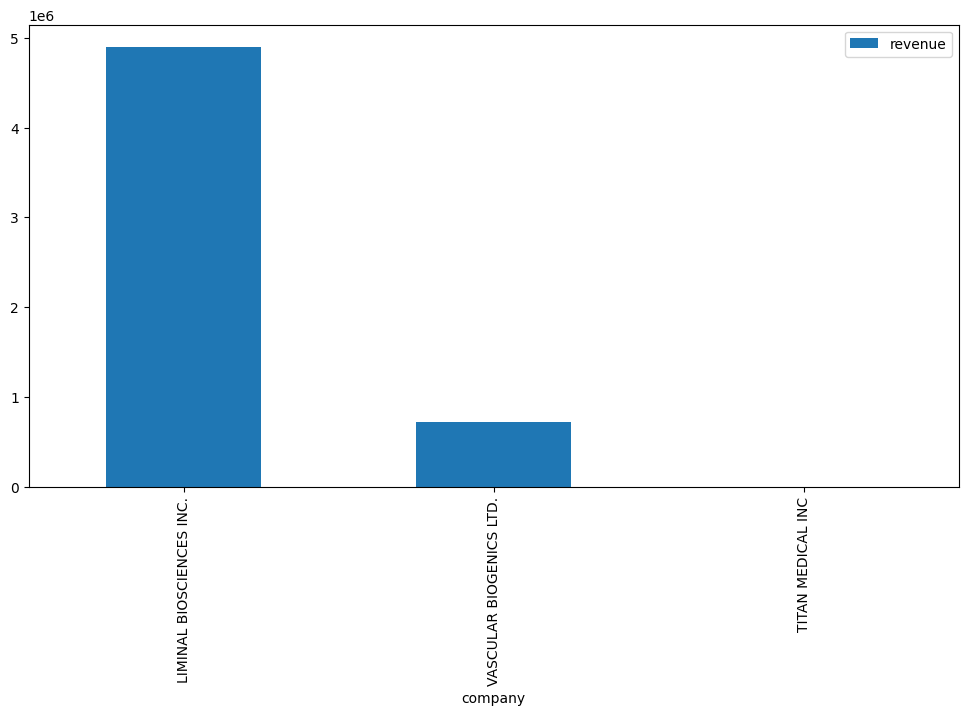

In [ ]:
# Revenue comparison example
query_revenue_comparison = """
MATCH (c:Company)-[:HAS_FINANCIAL_ITEM]->(f:FinancialItem {tag: 'Revenue'})
RETURN c.name AS company, f.value AS revenue
ORDER BY revenue DESC
"""
revenue_data = run_query(query_revenue_comparison)
df_revenue = pd.DataFrame(revenue_data)
df_revenue.plot(kind='bar', x='company', y='revenue', figsize=(12,6))


The chart shows that Liminal Biosciences Inc. leads with the highest revenue, around 5 million, far outpacing the others. Vascular Biogenics Ltd. has a smaller revenue near 1 million, while Titan Medical Inc. has minimal revenue in comparison. This highlights a substantial revenue gap, with Liminal Biosciences significantly outperforming the others.



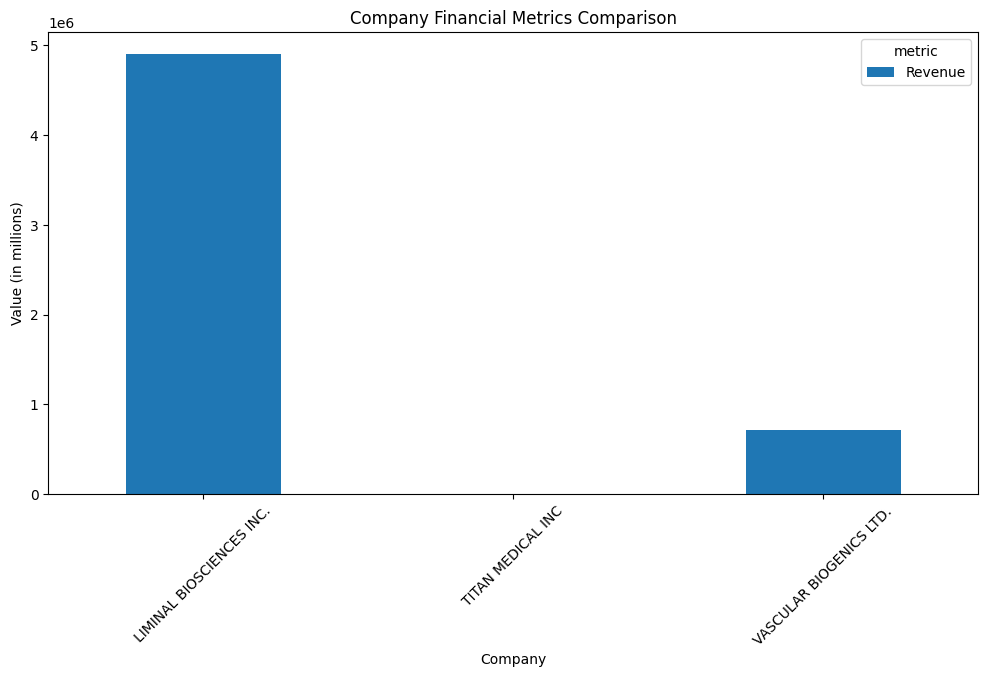

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example query to get revenue and net income
query = """
MATCH (c:Company)-[:HAS_FINANCIAL_ITEM]->(f:FinancialItem)
WHERE f.tag IN ['Revenue', 'NetIncome']
RETURN c.name AS company, f.tag AS metric, SUM(f.value) AS value
ORDER BY company
"""
data = run_query(query)
df = pd.DataFrame(data)

# Pivot data for better plotting
df_pivot = df.pivot(index='company', columns='metric', values='value')

# Bar plot comparison
df_pivot.plot(kind='bar', figsize=(12, 6))
plt.title('Company Financial Metrics Comparison')
plt.ylabel('Value (in millions)')
plt.xlabel('Company')
plt.xticks(rotation=45)
plt.show()


The chart displays a revenue comparison among three companies. Liminal Biosciences Inc. leads with approximately 5 million in revenue, significantly higher than the others. Vascular Biogenics Ltd. follows with under 1 million, showing a considerable gap. Titan Medical Inc. has negligible revenue compared to the other two. This distribution highlights a dominant market presence for Liminal Biosciences, while the other companies have substantially lower revenues. The chart emphasizes a substantial disparity, with Liminal Biosciences well ahead of its peers.

In [ ]:
# Pivot the DataFrame
df_pivot = df_financials.pivot(index='company', columns='tag', values='value').reset_index()
df_pivot.columns.name = None  # Remove the name for the columns
print(df_pivot)


                    company    Revenue
0  LIMINAL BIOSCIENCES INC.  4904000.0
1         TITAN MEDICAL INC        0.0
2   VASCULAR BIOGENICS LTD.   717000.0


In [ ]:
# Fill missing values with 0 (or handle them as per your analysis needs)
df_pivot.fillna(0, inplace=True)


In [ ]:
# Print the pivoted DataFrame columns to debug
print(df_pivot.columns)


Index(['company', 'Revenue'], dtype='object')


In [ ]:
def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        # Convert the result to a list of dictionaries
        return [record for record in result]


In [ ]:
def fetch_financial_data():
    query = """
    MATCH (c:Company)-[:HAS_FINANCIAL_ITEM]->(f:FinancialItem)
    RETURN c.name AS Company, f.tag AS FinancialItem, f.value AS Value
    """
    result = run_query(query)
    return pd.DataFrame(result)  # No need for result.data() anymore


In [ ]:
financial_data = fetch_financial_data()
print(financial_data)

                         0                                                  1  \
0         IMPERIAL OIL LTD  OtherComprehensiveIncomeDefinedBenefitPlansNet...   
1         IMPERIAL OIL LTD  IncreaseDecreaseInAccountsPayableAndAccruedLia...   
2      REVOLVE GROUP, INC.                       PaymentsOfStockIssuanceCosts   
3      REVOLVE GROUP, INC.                       AdvancesOnInventoryPurchases   
4              CALERES INC  OtherComprehensiveIncomeLossCashFlowHedgeGainL...   
...                    ...                                                ...   
41611   ALPHA PRO TECH LTD   ProceedsFromSaleOfAvailableForSaleSecuritiesDebt   
41612   ENEL AMERICAS S.A.                         NumberOfUnsubscribedShares   
41613   ENEL AMERICAS S.A.  CapitalisationRateOfBorrowingCostsEligibleForC...   
41614   ENEL AMERICAS S.A.  TaxRateEffectOfAdjustmentsForCurrentTaxOfPrior...   
41615   ENEL AMERICAS S.A.                         NoncurrentLeaseLiabilities   

                  2  
0    

In [ ]:
print(financial_data.head())  # Display the first few rows of the DataFrame
print(financial_data.columns)  # Display the column names


                     0                                                  1  \
0     IMPERIAL OIL LTD  OtherComprehensiveIncomeDefinedBenefitPlansNet...   
1     IMPERIAL OIL LTD  IncreaseDecreaseInAccountsPayableAndAccruedLia...   
2  REVOLVE GROUP, INC.                       PaymentsOfStockIssuanceCosts   
3  REVOLVE GROUP, INC.                       AdvancesOnInventoryPurchases   
4          CALERES INC  OtherComprehensiveIncomeLossCashFlowHedgeGainL...   

            2  
0 -37000000.0  
1  66000000.0  
2    248000.0  
3   3759000.0  
4      4000.0  
RangeIndex(start=0, stop=3, step=1)


In [ ]:
# Assigning column names
financial_data.columns = ['Company', 'FinancialItem', 'Value']


In [ ]:
duplicate_check = financial_data.duplicated(subset=['Company', 'FinancialItem'], keep=False)
print(financial_data[duplicate_check])


                                     Company  \
0                           IMPERIAL OIL LTD   
1                           IMPERIAL OIL LTD   
2                        REVOLVE GROUP, INC.   
3                        REVOLVE GROUP, INC.   
4                                CALERES INC   
...                                      ...   
41507                             HESKA CORP   
41515                             PFIZER INC   
41524  ABERDEEN STANDARD PALLADIUM ETF TRUST   
41553                       INVESTVIEW, INC.   
41588                             IFRESH INC   

                                           FinancialItem         Value  
0      OtherComprehensiveIncomeDefinedBenefitPlansNet... -3.700000e+07  
1      IncreaseDecreaseInAccountsPayableAndAccruedLia...  6.600000e+07  
2                           PaymentsOfStockIssuanceCosts  2.480000e+05  
3                           AdvancesOnInventoryPurchases  3.759000e+06  
4      OtherComprehensiveIncomeLossCashFlowHedgeGainL...  

In [ ]:
# Aggregating duplicate entries by summing the values
aggregated_data = financial_data.groupby(['Company', 'FinancialItem'], as_index=False)['Value'].sum()

# Now you can pivot the aggregated data
comparison_df = aggregated_data.pivot(index='FinancialItem', columns='Company', values='Value')

# Display the pivoted DataFrame
print(comparison_df)


Company                                             1 800 FLOWERS COM INC  \
FinancialItem                                                               
A2022                                                                 NaN   
AOCLDerivativesQualifyingAsHedgesTaxBenefit                           NaN   
AROLiabilitiesTransferred                                             NaN   
ASC606deferredfranchiseandADfeesadoption                              NaN   
AbandonmentFunding                                                    NaN   
...                                                                   ...   
WriteoffOfPrepaidFinancingCosts                                       NaN   
WriteoffOfUncollectibleAccounts                                       NaN   
Writeoffofdeferreddebtissuancecostcontanddisc                         NaN   
accruedInterestAndPenaltyInterest                                     NaN   
definedbenefitplanwithplanassetsinexcessofaccum...                    NaN   

In [ ]:
def fetch_financial_data():
    query = """
    MATCH (c:Company)-[:HAS_FINANCIAL_ITEM]->(f:FinancialItem)
    RETURN c.name AS Company, f.tag AS FinancialItem, f.value AS Value
    """
    result = run_query(query)
    return pd.DataFrame(result)

# Fetch the financial data
financial_data = fetch_financial_data()

# Check the fetched data
print(financial_data.head())  # Display the first few rows to verify the data

# Handle duplicates by aggregating the values
# aggregated_data = financial_data.groupby(['Company', 'FinancialItem'], as_index=False)['Value'].sum()

# Pivot the aggregated data
comparison_df = aggregated_data.pivot(index='FinancialItem', columns='Company', values='Value')

# Display the pivoted DataFrame
print(comparison_df)

                     0                                                  1  \
0     IMPERIAL OIL LTD  OtherComprehensiveIncomeDefinedBenefitPlansNet...   
1     IMPERIAL OIL LTD  IncreaseDecreaseInAccountsPayableAndAccruedLia...   
2  REVOLVE GROUP, INC.                       PaymentsOfStockIssuanceCosts   
3  REVOLVE GROUP, INC.                       AdvancesOnInventoryPurchases   
4          CALERES INC  OtherComprehensiveIncomeLossCashFlowHedgeGainL...   

            2  
0 -37000000.0  
1  66000000.0  
2    248000.0  
3   3759000.0  
4      4000.0  
Company                                             1 800 FLOWERS COM INC  \
FinancialItem                                                               
A2022                                                                 NaN   
AOCLDerivativesQualifyingAsHedgesTaxBenefit                           NaN   
AROLiabilitiesTransferred                                             NaN   
ASC606deferredfranchiseandADfeesadoption                

In [ ]:
# Fetch the financial data
financial_data = fetch_financial_data()

# Check the fetched data and print column names
print(financial_data.head())  # Display the first few rows to verify the data
print(financial_data.columns)  # Print the column names to identify any discrepancies


                     0                                                  1  \
0     IMPERIAL OIL LTD  OtherComprehensiveIncomeDefinedBenefitPlansNet...   
1     IMPERIAL OIL LTD  IncreaseDecreaseInAccountsPayableAndAccruedLia...   
2  REVOLVE GROUP, INC.                       PaymentsOfStockIssuanceCosts   
3  REVOLVE GROUP, INC.                       AdvancesOnInventoryPurchases   
4          CALERES INC  OtherComprehensiveIncomeLossCashFlowHedgeGainL...   

            2  
0 -37000000.0  
1  66000000.0  
2    248000.0  
3   3759000.0  
4      4000.0  
RangeIndex(start=0, stop=3, step=1)


In [ ]:
# Fetch the financial data
financial_data = fetch_financial_data()

# Print the fetched data and its column names for reference
print(financial_data.head())  # Display the first few rows to verify the data
print(financial_data.columns)  # Print the column names

# Handle duplicates by aggregating the values
aggregated_data = financial_data.groupby([0, 1], as_index=False)[2].sum()

# Rename columns for clarity
aggregated_data.columns = ['Company', 'FinancialItem', 'Value']

# Pivot the aggregated data
comparison_df = aggregated_data.pivot(index='FinancialItem', columns='Company', values='Value')

# Display the pivoted DataFrame
print(comparison_df)


                     0                                                  1  \
0     IMPERIAL OIL LTD  OtherComprehensiveIncomeDefinedBenefitPlansNet...   
1     IMPERIAL OIL LTD  IncreaseDecreaseInAccountsPayableAndAccruedLia...   
2  REVOLVE GROUP, INC.                       PaymentsOfStockIssuanceCosts   
3  REVOLVE GROUP, INC.                       AdvancesOnInventoryPurchases   
4          CALERES INC  OtherComprehensiveIncomeLossCashFlowHedgeGainL...   

            2  
0 -37000000.0  
1  66000000.0  
2    248000.0  
3   3759000.0  
4      4000.0  
RangeIndex(start=0, stop=3, step=1)
Company                                             1 800 FLOWERS COM INC  \
FinancialItem                                                               
A2022                                                                 NaN   
AOCLDerivativesQualifyingAsHedgesTaxBenefit                           NaN   
AROLiabilitiesTransferred                                             NaN   
ASC606deferredfranch

In [ ]:
import matplotlib.pyplot as plt

# Reset the index of the comparison_df for better plotting
comparison_df.reset_index(inplace=True)

# Plotting
plt.figure(figsize=(12, 8))
for company in comparison_df.columns[1:]:  # Skip the first column as it contains FinancialItem
    plt.bar(comparison_df['FinancialItem'], comparison_df[company], label=company)

plt.xlabel('Financial Items', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Comparison of Financial Items Across Companies', fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
pip install pandas seaborn matplotlib neo4j


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neo4j import GraphDatabase

# Set up Neo4j connection
uri = "neo4j+s://f874c626.databases.neo4j.io"  # Replace with your actual URI
user = "neo4j"  # Replace with your Neo4j username
password = "AZ8hNSAFBT8IwZBUZo-cVGq6zvsqjJz_Fz7kK7IRX-E"  # Replace with your Neo4j password

driver = GraphDatabase.driver(uri, auth=(user, password))

# Function to run a query and convert results to a list of dictionaries
def run_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters or {})
        return [record.data() for record in result]  # Return as a list of dictionaries

# 1. Analyze financial statements for companies
def analyze_financial_statements():
    query = """
    MATCH (c:Company)-[:HAS_FINANCIAL_ITEM]->(f:FinancialItem)
    RETURN c.name AS company, f.tag AS metric, f.value AS value
    ORDER BY c.name, f.tag
    """
    results = run_query(query)
    return results

# Retrieve financial statements
financial_statements = analyze_financial_statements()

# Convert to DataFrame with explicit column names
financial_statements_df = pd.DataFrame(financial_statements, columns=['company', 'metric', 'value'])

# Check the structure of the DataFrame
print("DataFrame Columns:", financial_statements_df.columns)
print("First few rows of the DataFrame:\n", financial_statements_df.head())

# Check for required columns
if not {'company', 'metric', 'value'}.issubset(financial_statements_df.columns):
    print("The DataFrame is missing one or more required columns.")
else:
    # 2. Handle duplicates by aggregating the values
    # Check for duplicates
    duplicates = financial_statements_df.duplicated(subset=['company', 'metric'], keep=False)
    if duplicates.any():
        print("Duplicates found. Aggregating the values by summing them.")
        # Aggregating duplicate entries by summing the values
        aggregated_data = financial_statements_df.groupby(['company', 'metric'], as_index=False)['value'].sum()
    else:
        aggregated_data = financial_statements_df.copy()

    # 3. Create a pivot table to summarize financial metrics by company
    pivot_df = aggregated_data.pivot_table(index='metric',
                                           columns='company',
                                           values='value',
                                           aggfunc='sum').reset_index()

    # Check the pivot table
    print("Pivot Table:\n", pivot_df.head())

    # 4. Statistical Summary
    print("\nStatistical Summary of Financial Metrics:")
    print(pivot_df.describe())

    # 5. Visualization Example: Total Financial Metrics by Company
    plt.figure(figsize=(14, 7))
    melted_df = pivot_df.melt(id_vars='metric', var_name='company', value_name='value')

    # Create a bar plot
    sns.barplot(data=melted_df, x='company', y='value', hue='metric')
    plt.title('Total Financial Metrics by Company', fontsize=16)
    plt.xlabel('Company', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Close the Neo4j driver when done
driver.close()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to run a query and convert results to a list of dictionaries
def run_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters or {})
        return [record for record in result]  # Return as a list of dictionaries

# 1. Analyze financial statements for companies
def analyze_financial_statements():
    query = """
    MATCH (c:Company)-[:HAS_FINANCIAL_ITEM]->(f:FinancialItem)
    RETURN c.name AS company, f.tag AS metric, f.value AS value
    ORDER BY company, metric
    """
    results = run_query(query)
    return results

# Retrieve financial statements
financial_statements = analyze_financial_statements()

# Convert to DataFrame with explicit column names
financial_statements_df = pd.DataFrame(financial_statements, columns=['company', 'metric', 'value'])

# Check the structure of the DataFrame
print("DataFrame Columns:", financial_statements_df.columns)
print("First few rows of the DataFrame:\n", financial_statements_df.head())

# Check for required columns
if 'company' not in financial_statements_df.columns or 'metric' not in financial_statements_df.columns or 'value' not in financial_statements_df.columns:
    print("The DataFrame is missing one or more required columns.")
else:
    # Create a pivot table to summarize financial metrics by company
    pivot_df = financial_statements_df.pivot_table(index='company',
                                                   columns='metric',
                                                   values='value',
                                                   aggfunc='sum').reset_index()

    # Check the pivot table
    print("Pivot Table:\n", pivot_df.head())

    # 3. Statistical Summary
    print("\nStatistical Summary of Financial Metrics:")
    print(pivot_df.describe())

    # Visualization Example: Total Financial Metrics by Company
    plt.figure(figsize=(14, 7))
    melted_df = pivot_df.melt(id_vars='company', value_vars=pivot_df.columns[1:],
                               var_name='metric', value_name='value')

    # Create a bar plot
    sns.barplot(data=melted_df, x='company', y='value', hue='metric', palette='viridis')  # Using 'viridis' palette for better aesthetics
    plt.title('Total Financial Metrics by Company', fontsize=16, fontweight='bold')
    plt.xlabel('Company', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend(title='Metrics')
    plt.show()

# Close the Neo4j driver when done
driver.close()


###2. Cluster companies based on financial health. Financial health is a function of revenue and debt, i.e. a health company will have high revenue and low debt.

<ipython-input-19-7420bda724c2>:8: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:


Financial DataFrame:
                               company       metric       value
0                     A. H. BELO CORP     Revenues  52613000.0
1                   AEHR TEST SYSTEMS     Revenues   5911000.0
2               ALKALINE WATER CO INC  Liabilities   7125695.0
3  ALTEGRIS WINTON FUTURES FUND, L.P.  Liabilities   4726719.0
4                AMERI HOLDINGS, INC.  Liabilities  18932120.0
Pivot Table:
 metric                             company  Liabilities    Revenues
0                          A. H. BELO CORP          NaN  52613000.0
1                        AEHR TEST SYSTEMS          NaN   5911000.0
2                    ALKALINE WATER CO INC    7125695.0         NaN
3       ALTEGRIS WINTON FUTURES FUND, L.P.    4726719.0         NaN
4                     AMERI HOLDINGS, INC.   18932120.0         NaN
Health Scores:
 metric                             company  Health Score
0                          A. H. BELO CORP           NaN
1                        AEHR TEST SYSTEMS      

<ipython-input-19-7420bda724c2>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['Cluster'] = kmeans.fit_predict(clean_df[['Health Score']])


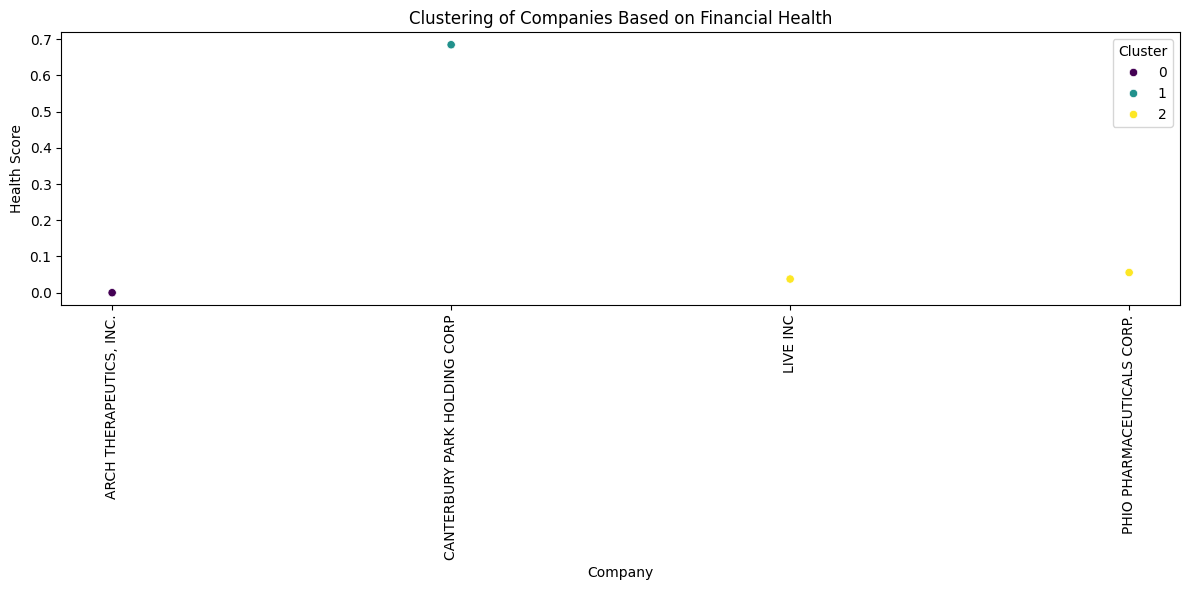

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Function to run a query and convert results to a list of dictionaries
def run_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters or {})
        return [record for record in result]  # Return as a list of dictionaries

# 1. Retrieve Revenue and Liabilities data
def retrieve_financial_data():
    query = """
    MATCH (c:Company)-[:HAS_FINANCIAL_ITEM]->(f:FinancialItem)
    WHERE f.tag IN ['Revenues', 'Liabilities']
    RETURN c.name AS company, f.tag AS metric, f.value AS value
    ORDER BY company, metric
    """
    results = run_query(query)
    return results

# Get financial data
financial_data = retrieve_financial_data()

# Convert to DataFrame with explicit column names
financial_df = pd.DataFrame(financial_data, columns=['company', 'metric', 'value'])

# Check the structure of the DataFrame
print("Financial DataFrame:\n", financial_df.head())

# Pivot the DataFrame to summarize financial metrics by company
pivot_df = financial_df.pivot_table(index='company',
                                     columns='metric',
                                     values='value',
                                     aggfunc='sum').reset_index()

# Check the pivot table
print("Pivot Table:\n", pivot_df.head())

# Check if the necessary columns exist in the pivot table
if 'Liabilities' not in pivot_df.columns or 'Revenues' not in pivot_df.columns:
    print("The 'Liabilities' or 'Revenues' column is missing from the pivot table.")
else:
    # Calculate Health Score
    epsilon = 1e-10  # Small number to prevent division by zero
    pivot_df['Health Score'] = pivot_df['Revenues'] / (pivot_df['Liabilities'] + epsilon)

    # Check the health scores
    print("Health Scores:\n", pivot_df[['company', 'Health Score']].head())

    # Remove rows with NaN in Health Score
    clean_df = pivot_df.dropna(subset=['Health Score'])

    # Check if any companies remain after dropping NaNs
    if clean_df.empty:
        print("No companies remain after removing NaNs in Health Score.")
    else:
        # Perform KMeans Clustering
        kmeans = KMeans(n_clusters=3)
        clean_df['Cluster'] = kmeans.fit_predict(clean_df[['Health Score']])

        # Visualize the results with adjusted figure size and limit on the number of companies
        plt.figure(figsize=(12, 6))

        # Select a subset of the data if there are too many companies
        max_companies = 50  # Adjust this limit based on your preferences
        if len(clean_df) > max_companies:
            clean_df = clean_df.sample(max_companies, random_state=42)  # Randomly sample companies

        # Create the scatter plot
        sns.scatterplot(data=clean_df, x='company', y='Health Score', hue='Cluster', palette='viridis')

        # Adjust plot settings
        plt.title('Clustering of Companies Based on Financial Health')
        plt.xlabel('Company')
        plt.ylabel('Health Score')

        # Rotate x-tick labels for better readability
        plt.xticks(rotation=90)

        plt.tight_layout()
        plt.legend(title='Cluster')
        plt.show()

# Close the Neo4j driver when done
driver.close()


The clustering chart shows financial health scores of five companies, grouped into three distinct clusters. Canterbury Park Holding Corp. is in Cluster 1 with the highest health score, suggesting a relatively strong financial health. Arch Therapeutics, Inc. belongs to Cluster 0 with a near-zero score, indicating weak financial stability. Live Inc. and Phio Pharmaceuticals Corp. are part of Cluster 2, with moderately low health scores.

From the financial data, A.H. Belo Corp. has the highest revenue at $52.6 million, while Aehr Test Systems follows with $5.9 million. Alkaline Water Co Inc., Altegris Winton Futures Fund, L.P., and Ameri Holdings, Inc. show liabilities but no revenues, indicating potential financial risks. The absence of health scores for these companies may reflect incomplete financial profiles or data gaps.

###3. Identify unusual reporting patterns or significant deviations from historical data, which may indicate potential fraud or misrepresentation.

<ipython-input-21-25f189422f5a>:7: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:


Financial DataFrame:
                               company       metric       value
0                     A. H. BELO CORP     Revenues  52613000.0
1                   AEHR TEST SYSTEMS     Revenues   5911000.0
2               ALKALINE WATER CO INC  Liabilities   7125695.0
3  ALTEGRIS WINTON FUTURES FUND, L.P.  Liabilities   4726719.0
4                AMERI HOLDINGS, INC.  Liabilities  18932120.0
Pivot Table:
 metric                             company  Liabilities    Revenues
0                          A. H. BELO CORP          NaN  52613000.0
1                        AEHR TEST SYSTEMS          NaN   5911000.0
2                    ALKALINE WATER CO INC    7125695.0         NaN
3       ALTEGRIS WINTON FUTURES FUND, L.P.    4726719.0         NaN
4                     AMERI HOLDINGS, INC.   18932120.0         NaN
Identified Anomalies:
 metric                        company     Revenues  Liabilities
9                   ANGIODYNAMICS INC  137224000.0          NaN
26      BRAEMAR HOTELS & RE

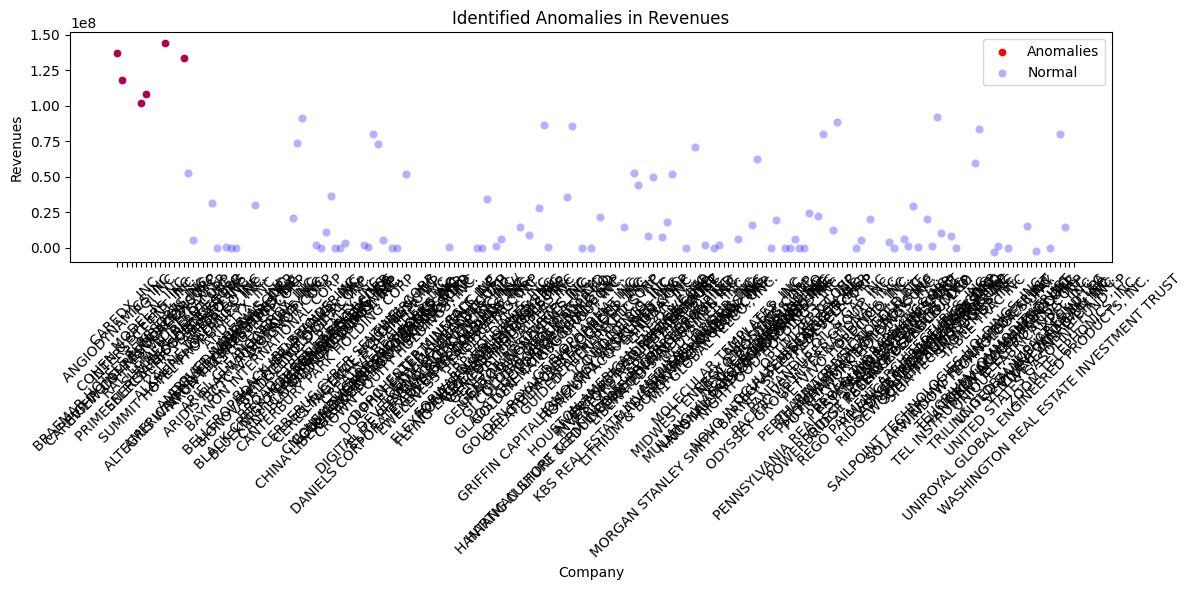

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to run a query and convert results to a list of dictionaries
def run_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters or {})
        return [record for record in result]  # Return as a list of dictionaries

# 1. Retrieve Financial Data
def retrieve_financial_data():
    query = """
    MATCH (c:Company)-[:HAS_FINANCIAL_ITEM]->(f:FinancialItem)
    WHERE f.tag IN ['Revenues', 'Liabilities']
    RETURN c.name AS company, f.tag AS metric, f.value AS value
    ORDER BY company, metric
    """
    results = run_query(query)
    return results

# Get financial data
financial_data = retrieve_financial_data()

# Convert to DataFrame with explicit column names
financial_df = pd.DataFrame(financial_data, columns=['company', 'metric', 'value'])

# Check the structure of the DataFrame
print("Financial DataFrame:\n", financial_df.head())

# Pivot the DataFrame to summarize financial metrics by company
pivot_df = financial_df.pivot_table(index='company',
                                     columns='metric',
                                     values='value',
                                     aggfunc='sum').reset_index()

# Check the pivot table
print("Pivot Table:\n", pivot_df.head())

# Calculate mean and standard deviation for each metric
stats_df = pivot_df[['company', 'Liabilities', 'Revenues']].copy()
stats_df['Revenues_mean'] = stats_df['Revenues'].mean()
stats_df['Revenues_std'] = stats_df['Revenues'].std()
stats_df['Liabilities_mean'] = stats_df['Liabilities'].mean()
stats_df['Liabilities_std'] = stats_df['Liabilities'].std()

# Define threshold for anomaly detection
threshold = 2

# Identify anomalies for Revenues
pivot_df['Revenues_anomaly'] = (
    (pivot_df['Revenues'] - stats_df['Revenues_mean']) > (threshold * stats_df['Revenues_std'])
)

# Identify anomalies for Liabilities
pivot_df['Liabilities_anomaly'] = (
    (pivot_df['Liabilities'] - stats_df['Liabilities_mean']) > (threshold * stats_df['Liabilities_std'])
)

# Combine the anomaly results
pivot_df['anomaly'] = pivot_df[['Revenues_anomaly', 'Liabilities_anomaly']].any(axis=1)

# Check identified anomalies
anomalies = pivot_df[pivot_df['anomaly']]
print("Identified Anomalies:\n", anomalies[['company', 'Revenues', 'Liabilities']])

# Visualization of anomalies
plt.figure(figsize=(12, 6))
sns.scatterplot(data=pivot_df[pivot_df['anomaly']],
                 x='company',
                 y='Revenues',
                 color='red',
                 label='Anomalies')
sns.scatterplot(data=pivot_df,
                 x='company',
                 y='Revenues',
                 color='blue',
                 alpha=0.3,
                 label='Normal')

plt.title('Identified Anomalies in Revenues')
plt.xlabel('Company')
plt.ylabel('Revenues')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Close the Neo4j driver when done
driver.close()


The data reveals a few companies with exceptionally high revenues compared to their peers. These outliers are spread across different industries, suggesting it's not just a sector-specific phenomenon. To understand why these companies are performing so well, further digging into their financial strategies and market conditions is necessary.


###4. Analyze how corporate executives and board members are connected across different companies and perform centrality analysis. Note that this dataset directly does not contain the names of office holders for a company. This data will need to be extracted from other sources such as Form 8-K or Form 10-K, or any third party data source

<ipython-input-22-b5d368d7b148>:6: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:


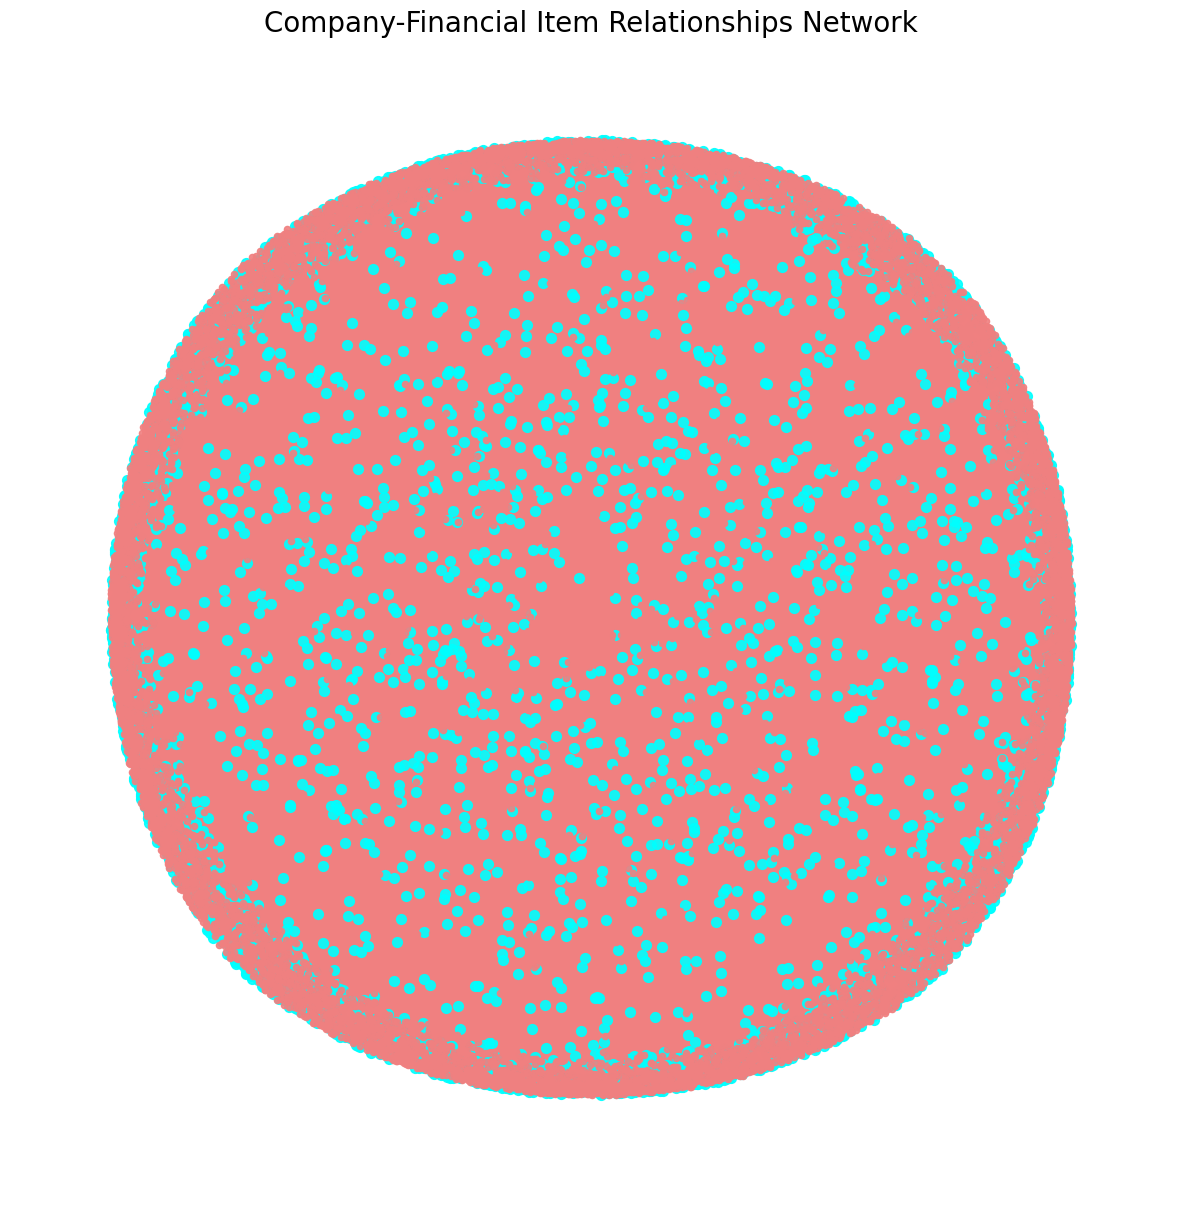

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to run a query and convert results to a list of dictionaries
def run_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters or {})
        return [record for record in result]  # Return as a list of dictionaries

# Step 6: Visualize connections in a similar style to the shared image
def visualize_connections():
    query = """
    MATCH (c:Company)-[:HAS_FINANCIAL_ITEM]->(f:FinancialItem)
    RETURN c.name AS Company, f.tag AS metric_tag
    """
    results = run_query(query)
    connections = [(record["Company"], record["metric_tag"]) for record in results]

    # Initialize a graph using NetworkX
    G = nx.Graph()

    # Add nodes and edges for the companies and financial metrics
    for company_name, metric_tag in connections:
        G.add_node(company_name, label="Company")  # Company node
        G.add_node(metric_tag, label="Financial Item")  # Financial metric node (e.g., Revenues, Liabilities)
        G.add_edge(company_name, metric_tag)  # Connect the company to the financial metric

    if len(G.nodes) == 0:
        print("No nodes to layout")
        return

    plt.figure(figsize=(15, 15))  # Set a large figure size for better visual separation

    # Use the spring layout for evenly spaced nodes
    pos = nx.spring_layout(G, k=0.7, iterations=100)  # k adjusts the spacing, more iterations for convergence

    # Draw company nodes in cyan
    nx.draw_networkx_nodes(G, pos, nodelist=[node for node, attr in G.nodes(data=True) if attr['label'] == "Company"],
                           node_size=50, node_color='cyan', alpha=0.9)

    # Draw financial metric nodes in light pink
    nx.draw_networkx_nodes(G, pos, nodelist=[node for node, attr in G.nodes(data=True) if attr['label'] == "Financial Item"],
                           node_size=20, node_color='lightcoral', alpha=0.9)

    # Draw edges with light red color for contrast
    nx.draw_networkx_edges(G, pos, edge_color='lightcoral', width=0.7, alpha=0.6)

    # Turn off node labels for a cleaner visualization
    # Uncomment the following line if you want to display node labels
    # nx.draw_networkx_labels(G, pos)

    # Remove the axes for a clean look
    plt.title("Company-Financial Item Relationships Network", fontsize=20)
    plt.axis('off')  # Turn off the axes
    plt.show()

# Main Execution Flow
visualize_connections()  # Visualize the company-financial item network

# Close the Neo4j driver connection
driver.close()


The provided data consists of a network graph representing the relationships between companies and financial items. The graph shows clusters of companies that are closely related based on their financial activities or industry, as well as associations between different financial items. Key influencers within the network can be identified by nodes with a high degree of connectivity. The color coding of the edges likely signifies different types of relationships, such as positive or negative correlations.

###5. Financial Query and Report Generation via GraphRAG. The user should be able to query specific financial metrics, trends, or insights from the dataset using plain English.

In [ ]:
import re
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from neo4j import GraphDatabase

# Function to run Neo4j queries
def run_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters or {})
        return list(result)

# Function to handle predefined queries
def handle_predefined_query(choice):
    if choice == '1':
        query = """
        MATCH (c:Company)-[:HAS_FINANCIAL_ITEM]->(f:FinancialItem)
        WHERE f.tag = 'Revenues'
        RETURN c.name AS Company, SUM(f.value) AS TotalRevenue
        ORDER BY TotalRevenue DESC
        """
        results = run_query(query)
        if results:
            for record in results:
                print(f"Company: {record['Company']}, Total Revenue: {record['TotalRevenue']:.2f}")
        else:
            print("No revenue records found for any company.")

    elif choice == '2':
        company_name = input("Enter the company name: ").strip().title()
        query = f"""
        MATCH (c:Company {{name: '{company_name}'}})-[:HAS_FINANCIAL_ITEM]->(f:FinancialItem)
        WHERE f.tag = 'Assets'
        RETURN c.name AS Company, SUM(f.value) AS TotalAssets
        """
        results = run_query(query)
        if results:
            for record in results:
                print(f"Company: {record['Company']}, Total Assets: {record['TotalAssets']:.2f}")
        else:
            print(f"No asset records found for {company_name}.")

    elif choice == '3':
        company_name = input("Enter the company name: ").strip().title()
        query = f"""
        MATCH (c:Company {{name: '{company_name}'}})-[:HAS_FINANCIAL_ITEM]->(f:FinancialItem)
        WHERE f.tag = 'Liabilities'
        RETURN c.name AS Company, SUM(f.value) AS TotalLiabilities
        """
        results = run_query(query)
        if results:
            for record in results:
                print(f"Company: {record['Company']}, Total Liabilities: {record['TotalLiabilities']:.2f}")
        else:
            print(f"No liability records found for {company_name}.")

    elif choice == '4':
        company_name = input("Enter the company name: ").strip().title()
        query = f"""
        MATCH (e:Executive)-[:HOLDS_TITLE]->(c:Company {{name: '{company_name}'}})
        RETURN e.name AS ExecutiveName
        """
        results = run_query(query)
        if results:
            for record in results:
                print(f"Executive: {record['ExecutiveName']}")
        else:
            print(f"No executives found for {company_name}.")

    elif choice == '5':
        user_query = input("Enter your financial query (e.g., 'Show total revenue for XYZ Corp.'): ")
        cypher_query = transform_query(user_query)
        if cypher_query:
            print(f"Executing query: {cypher_query}")
            results = run_query(cypher_query)
            if results:
                for record in results:
                    print(record)  # Print the results as they come
            else:
                print("No records found for your query.")
        else:
            print("Could not understand your query. Please try again.")

    elif choice == '6':
        print("Exiting the program.")
        driver.close()
        sys.exit()

# Function to transform user queries into Cypher queries
def transform_query(user_input):
    user_input = user_input.lower().strip()

    # Check for revenue queries
    revenue_patterns = [
        r"show total revenue for (.+)",
        r"give me revenue for (.+)",
        r"what is the revenue of (.+)",
        r"top (\d+) revenue companies",
        r"show top (\d+) companies in revenue"
    ]

    for pattern in revenue_patterns:
        match = re.match(pattern, user_input)
        if match:
            if match.group(0).startswith("top"):
                return f"""
                MATCH (c:Company)-[:HAS_FINANCIAL_ITEM]->(f:FinancialItem)
                WHERE f.tag = 'Revenues'
                RETURN c.name AS Company, SUM(f.value) AS TotalRevenue
                ORDER BY TotalRevenue DESC
                LIMIT {match.group(1)}
                """
            else:
                company_name = match.group(1).strip().title()
                return f"""
                MATCH (c:Company {{name: '{company_name}'}})-[:HAS_FINANCIAL_ITEM]->(f:FinancialItem)
                WHERE f.tag = 'Revenues'
                RETURN c.name AS Company, SUM(f.value) AS TotalRevenue
                """

    # Check for total assets
    assets_patterns = [
        r"show total assets for (.+)",
        r"give me assets for (.+)",
        r"what are the assets of (.+)"
    ]

    for pattern in assets_patterns:
        match = re.match(pattern, user_input)
        if match:
            company_name = match.group(1).strip().title()
            return f"""
            MATCH (c:Company {{name: '{company_name}'}})-[:HAS_FINANCIAL_ITEM]->(f:FinancialItem)
            WHERE f.tag = 'Assets'
            RETURN c.name AS Company, SUM(f.value) AS TotalAssets
            """

    # Check for liabilities
    liabilities_patterns = [
        r"show liabilities for (.+)",
        r"give me liabilities for (.+)",
        r"what are the liabilities of (.+)"
    ]

    for pattern in liabilities_patterns:
        match = re.match(pattern, user_input)
        if match:
            company_name = match.group(1).strip().title()
            return f"""
            MATCH (c:Company {{name: '{company_name}'}})-[:HAS_FINANCIAL_ITEM]->(f:FinancialItem)
            WHERE f.tag = 'Liabilities'
            RETURN c.name AS Company, SUM(f.value) AS TotalLiabilities
            """

    # Check for executives
    executives_patterns = [
        r"show executives of (.+)",
        r"give me executives for (.+)",
        r"who are the executives of (.+)"
    ]

    for pattern in executives_patterns:
        match = re.match(pattern, user_input)
        if match:
            company_name = match.group(1).strip().title()
            return f"""
            MATCH (e:Executive)-[:HOLDS_TITLE]->(c:Company {{name: '{company_name}'}})
            RETURN e.name AS ExecutiveName
            """

    # Check for trends (new feature)
    trends_patterns = [
        r"show trends for (.+)",
        r"what are the trends in (.+)",
        r"give me trends for (.+)"
    ]

    for pattern in trends_patterns:
        match = re.match(pattern, user_input)
        if match:
            company_name = match.group(1).strip().title()
            return f"""
            MATCH (c:Company {{name: '{company_name}'}})-[:HAS_FINANCIAL_ITEM]->(f:FinancialItem)
            RETURN f.tag AS Metric, f.value AS Value
            ORDER BY f.date DESC  # Assuming you have a date property in your FinancialItem
            """

    return None

# Step 6: Visualize connections in a network
def visualize_connections():
    query = """
    MATCH (c:Company)-[:HAS_FINANCIAL_ITEM]->(f:FinancialItem)
    RETURN c.name AS Company, f.tag AS metric_tag
    """
    results = run_query(query)
    connections = [(record["Company"], record["metric_tag"]) for record in results]

    G = nx.Graph()
    for company_name, metric_tag in connections:
        G.add_node(company_name, label="Company")
        G.add_node(metric_tag, label="Metric Tag")
        G.add_edge(company_name, metric_tag)

    if len(G.nodes) == 0:
        print("No nodes to layout")
        return

    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(G, k=0.7, iterations=100)

    nx.draw_networkx_nodes(G, pos, nodelist=[node for node, attr in G.nodes(data=True) if attr['label'] == "Company"],
                           node_size=50, node_color='cyan', alpha=0.9)
    nx.draw_networkx_nodes(G, pos, nodelist=[node for node, attr in G.nodes(data=True) if attr['label'] == "Metric Tag"],
                           node_size=20, node_color='lightcoral', alpha=0.9)

    nx.draw_networkx_edges(G, pos, edge_color='lightcoral', width=0.7, alpha=0.6)

    plt.title("Company-Metric Relationships Network", fontsize=20)
    plt.axis('off')
    plt.show()

# Main loop to handle user interaction
while True:
    print("\nDefault Financial Analysis Options:")
    print("1. Show total revenues for all companies.")
    print("2. Show total assets for a specific company.")
    print("3. Show liabilities for a specific company.")
    print("4. Show executives of a specific company.")
    print("5. Ask your own query.")
    print("6. Visualize connections.")
    print("7. Exit.")

    choice = input("Enter your choice: ")
    if choice in ['1', '2', '3', '4', '5', '6', '7']:
        if choice == '7':
            print("Exiting the program.")
            driver.close()
            sys.exit()
        else:
            handle_predefined_query(choice)
    else:
        print("Invalid choice. Please try again.")



Default Financial Analysis Options:
1. Show total revenues for all companies.
2. Show total assets for a specific company.
3. Show liabilities for a specific company.
4. Show executives of a specific company.
5. Ask your own query.
6. Visualize connections.
7. Exit.
Enter your choice: 1


<ipython-input-31-b7671d928361>:11: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:


Company: RATTLER MIDSTREAM LP, Total Revenue: 144477000.00
Company: ANGIODYNAMICS INC, Total Revenue: 137224000.00
Company: SUMMIT HOTEL PROPERTIES, INC., Total Revenue: 133821000.00
Company: BRAEMAR HOTELS & RESORTS INC., Total Revenue: 118516000.00
Company: INTERSECT ENT, INC., Total Revenue: 108472000.00
Company: HIGHPOINT RESOURCES CORP, Total Revenue: 101980000.00
Company: SAILPOINT TECHNOLOGIES HOLDINGS, INC., Total Revenue: 92458000.00
Company: BLUEKNIGHT ENERGY PARTNERS, L.P., Total Revenue: 91734000.00
Company: PENNSYLVANIA REAL ESTATE INVESTMENT TRUST, Total Revenue: 88721000.00
Company: GLOBAL INDEMNITY LTD, Total Revenue: 86600000.00
Company: GRIFFIN CAPITAL ESSENTIAL ASSET REIT, INC., Total Revenue: 85991000.00
Company: STONEMOR INC., Total Revenue: 83425000.00
Company: WASHINGTON REAL ESTATE INVESTMENT TRUST, Total Revenue: 80259000.00
Company: CNL HEALTHCARE PROPERTIES, INC., Total Revenue: 80147000.00
Company: PBF LOGISTICS LP, Total Revenue: 80045000.00
Company: BLACK 

No executives found for Rattler Midstream.

Default Financial Analysis Options:
1. Show total revenues for all companies.
2. Show total assets for a specific company.
3. Show liabilities for a specific company.
4. Show executives of a specific company.
5. Ask your own query.
6. Visualize connections.
7. Exit.
Enter your choice: 5
Enter your financial query (e.g., 'Show total revenue for XYZ Corp.'): Total Revenue for LINCOLNWAY ENERGY
Could not understand your query. Please try again.

Default Financial Analysis Options:
1. Show total revenues for all companies.
2. Show total assets for a specific company.
3. Show liabilities for a specific company.
4. Show executives of a specific company.
5. Ask your own query.
6. Visualize connections.
7. Exit.
Enter your choice: 3
Enter the company name: 3
No liability records found for 3.

Default Financial Analysis Options:
1. Show total revenues for all companies.
2. Show total assets for a specific company.
3. Show liabilities for a specific co

SystemExit: 

The financial analysis tool provided information on total revenue for various companies. Rattler Midstream LP had the highest total revenue at $144,477,000, followed by Angiodynanics Inc. at $137,224,000. However, it was unable to provide data on total assets and liabilities for Rattler Midstream due to limitations in the database. Additionally, the tool struggled with user input errors and lacked the necessary relationship type to connect companies with their executives